In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk # natural language tool kit
import contractions
import string
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
from nltk import pos_tag, word_tokenize   
import random
import re

from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/muchlogic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/muchlogic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/muchlogic/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/muchlogic/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/muchlogic/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [65]:
train = pd.read_csv('./train.tsv', sep='\t')
test = pd.read_csv('./test 2.tsv', sep = '\t')

The sentiment labels are:

0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive

4 - positive

In [66]:
# Remove grammar, tokenize, and lemmatize the sentences
def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['Phrase']):
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
        
        # remove stop words:
        new_words = [char for char in words if char.lower() not in stopwords.words('english')]
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

In [67]:
train_sen = clean_sentences(train)
test_sen = clean_sentences(test)

100%|█████████████████████████████████████████████████████████████████████████████████████| 66292/66292 [00:57<00:00, 1150.75it/s]


In [68]:
print(len(train['Phrase']))
print(len(test['Phrase']))

156060
66292


In [69]:
print(len(train_sen))
print(len(test_sen))

156060
66292


In [70]:
target=train.Sentiment.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

In [71]:
target

array([1, 2, 2, ..., 3, 2, 2])

In [72]:
X_train,X_val,y_train,y_val = train_test_split(train_sen,y_target,
                                             test_size=0.2,stratify=y_target)

In [73]:
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
print(len(list(unique_words)))
print(len_max)

100%|█████████████████████████████████████████████████████████████████████████████████| 124848/124848 [00:00<00:00, 507821.66it/s]

13733
48


In [99]:
vocab_size = len(list(unique_words))
embedding_dim = 300
max_length = len_max
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [74]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sen)


X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

print(X_train.shape,X_val.shape,X_test.shape)

(124848, 48) (31212, 48) (66292, 48)


In [75]:
X_train

array([[   0,    0,    0, ...,   26, 8403,  224],
       [   0,    0,    0, ...,    4, 6329, 1864],
       [   0,    0,    0, ...,  140,  214,   76],
       ...,
       [   0,    0,    0, ...,   39,    4, 2105],
       [   0,    0,    0, ...,    0,   14, 4594],
       [   0,    0,    0, ...,    0,  674,  283]], dtype=int32)

In [97]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train,y_train)
print(model.score(X_val, y_val))
y_pred = model.predict(X_val)

0.47683583237216454


ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (2).

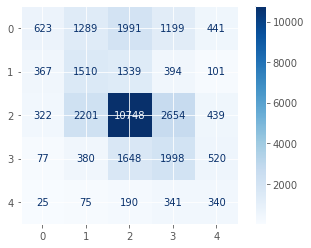

In [98]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pred.argmax(axis=1), y_val.argmax(axis=1)), display_labels=np.unique(y_val))
disp.plot(cmap='Blues') 
plt.grid(False)

In [100]:
from keras.models import Sequential
from keras.layers import Dense,Bidirectional,LSTM,Activation,Dropout
from keras.layers.embeddings import Embedding

### Building a stack of layers with keras
* Embedding: Convert words of similar meanings to vector representation
* Bidirectional: Store sequence in memory using an RNN, but it's bidirectional because it also stores future values
* Dense: Regular NN layer

In [101]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length = max_length),
    Bidirectional(LSTM(128, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True)),
    Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = False)),
    Dense(128,activation = 'relu'),
    Dense(y_target.shape[1],activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

2022-04-26 13:50:16.214552: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Stop training when the model has stopped improving!

In [102]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(min_delta = 0.001,
                               mode = 'max',
                               monitor = 'val_accuracy',
                               patience = 2)
callback = [early_stopping]

In [103]:
num_epochs = 4

history = model.fit(X_train,y_train,
                    validation_data = (X_val, y_val),
                    epochs = num_epochs,
                    batch_size = 256,
                    verbose = 1,
                    callbacks = callback)

Epoch 1/4
488/488 [==============================] - 478s 963ms/step - loss: 0.9891 - accuracy: 0.6022 - val_loss: 0.8468 - val_accuracy: 0.6525
Epoch 2/4
488/488 [==============================] - 480s 983ms/step - loss: 0.7760 - accuracy: 0.6806 - val_loss: 0.8004 - val_accuracy: 0.6693
Epoch 3/4
488/488 [==============================] - 484s 992ms/step - loss: 0.7007 - accuracy: 0.7076 - val_loss: 0.8085 - val_accuracy: 0.6686
Epoch 4/4
488/488 [==============================] - 472s 967ms/step - loss: 0.6525 - accuracy: 0.7254 - val_loss: 0.8066 - val_accuracy: 0.6747
